#1. Configurando Ambiente

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision,df_bitcoin_limpio

In [ ]:
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'

Python 3.10.11
------
Name: pandas
Version: 1.5.3
------
Name: numpy
Version: 1.22.4
------
Name: matplotlib
Version: 3.7.1


#2. Obtención de datos

#2.1. Precios Históricos de Bitcoin

In [2]:
def importar_base_bitcoin():
  global df_bitcoin
  df_bitcoin = yf.Ticker("BTC-USD").history(period='7d', interval='5m')


In [3]:
#Base Historica de precios del Bitcoin
importar_base_bitcoin()
df_bitcoin.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-05-15 00:00:00+00:00,26931.384766,26940.218750,26927.855469,26939.564453,0,0.0,0.0
2023-05-15 00:05:00+00:00,26942.525391,26942.525391,26920.029297,26920.029297,0,0.0,0.0
2023-05-15 00:10:00+00:00,26918.232422,26935.404297,26914.136719,26935.404297,0,0.0,0.0
2023-05-15 00:15:00+00:00,26919.871094,26919.871094,26811.279297,26812.771484,90236928,0.0,0.0
2023-05-15 00:20:00+00:00,26818.732422,26837.500000,26808.048828,26834.156250,38383616,0.0,0.0


#2.2. Indicadores de Tendencia

In [4]:
def extraer_tendencias():
  global precio_actual,tendencia
  headers={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36'}
  url="https://coinmarketcap.com/"
  respuesta=requests.get(url,headers=headers)
  soup=BeautifulSoup(respuesta.content,'html.parser')
  #Filtro para el valor del Precio del Bitcoin
  precios=soup.findAll('div',{'class':['sc-cadad039-0 clgqXO fall','sc-cadad039-0 clgqXO rise','sc-cadad039-0 clgqXO']})
  precio_actual=float(precios[0].get_text().replace('$','').replace(',',''))
  #Filtro para la tendencia
  span_element = soup.findAll('span', {'class': ['sc-97d6d2ca-0 cYiHal','sc-97d6d2ca-0 bQjSqS']})[0]
  if 'sc-97d6d2ca-0 cYiHal' in ' '.join(span_element['class']):
      tendencia = 'Alta'
  else:
      tendencia = 'Baja'


In [5]:
extraer_tendencias()
print('Bitcoin precio: ',precio_actual)
print('Tendencia: ',tendencia)

Bitcoin precio:  27183.76
Tendencia:  Alta


# 3. Limpieza de Datos

In [6]:
df_bitcoin_limpio=df_bitcoin.copy()
df_bitcoin_limpio.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-05-15 00:00:00+00:00,26931.384766,26940.218750,26927.855469,26939.564453,0,0.0,0.0
2023-05-15 00:05:00+00:00,26942.525391,26942.525391,26920.029297,26920.029297,0,0.0,0.0
2023-05-15 00:10:00+00:00,26918.232422,26935.404297,26914.136719,26935.404297,0,0.0,0.0
2023-05-15 00:15:00+00:00,26919.871094,26919.871094,26811.279297,26812.771484,90236928,0.0,0.0
2023-05-15 00:20:00+00:00,26818.732422,26837.500000,26808.048828,26834.156250,38383616,0.0,0.0


In [7]:
def limpieza_datos():
  global media_bitcoin,df_bitcoin_limpio
  #Eliminando Indices Duplicados en el DataFrame -> df_bitcoin_limpio.index.drop_duplicates(inplace=True)
  #Verificar si en la columna Close hay valores nulos
  df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin_limpio['Close'].isnull()]
  #eliminamos los datos de la columna Volume que no sean mayor que 0
  df_bitcoin_limpio=df_bitcoin_limpio[df_bitcoin_limpio['Volume']>0]
  #Eliminamos Outliers
  valor=df_bitcoin_limpio['Close']
  q1 = valor.quantile(0.25)
  q3 = valor.quantile(0.75)
  iiq = q3 - q1
  limite_inferior=q1-1.5*iiq
  limite_superior=q3+1.5*iiq
  seleccion=((valor>=limite_inferior)&(valor<=limite_superior))
  df_bitcoin_limpio=df_bitcoin_limpio[seleccion]
  media_bitcoin=df_bitcoin_limpio['Close'].mean()
  media_bitcoin

La media es 27120.21498373507


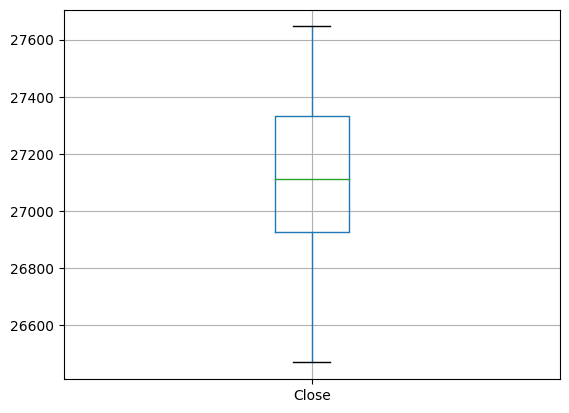

In [8]:
limpieza_datos()
df_bitcoin_limpio.boxplot(['Close'])
print(f'La media es {media_bitcoin}')

#4. Tomar Decisiones

In [9]:
def tomar_decisiones():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision,df_bitcoin_limpio
  if precio_actual>=media_bitcoin and tendencia =='Baja':
    algoritmo_decision='Vender'
  elif precio_actual<media_bitcoin and tendencia=='Alta':
    algoritmo_decision='Comprar'
  else:
    algoritmo_decision='Esperar'

In [10]:
#mostramos la desicion del algoritmo
tomar_decisiones()
print('Precio Promedio del Bitcoin: ',media_bitcoin)
print('Precio Actual del Bitcoin: ',precio_actual)
print('Tendencia: ',tendencia)
print('Desicion del Algoritmo: ',algoritmo_decision)

Precio Promedio del Bitcoin:  27120.21498373507
Precio Actual del Bitcoin:  27183.76
Tendencia:  Alta
Desicion del Algoritmo:  Esperar


#5. Visualización

In [11]:
def visualizacion():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision,df_bitcoin_limpio
  #Adicionamos una nueva columna en el dataFrame
  df_bitcoin['Promedio'] = media_bitcoin
  #Tamaño del Gráfico
  plt.figure(figsize=(16,5))
  #Titulo al Gráfico
  plt.title('Bitcoin')
  #Dibujar linea para los datos de la columna Close
  df_bitcoin['Close'].plot(label='Precio Actual')
  #Dibujar linea para los datos de la columna Promedio
  df_bitcoin['Promedio'].plot(label='Promedio')
  plt.xlabel('Fecha')
  plt.ylabel('Precio')
  plt.annotate(f'Decisión: {algoritmo_decision}', xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]),xytext=(-130, 80), textcoords='offset points',
  arrowprops=dict(arrowstyle='->'),fontsize=14)
  # Mostrar gráfico
  plt.show()

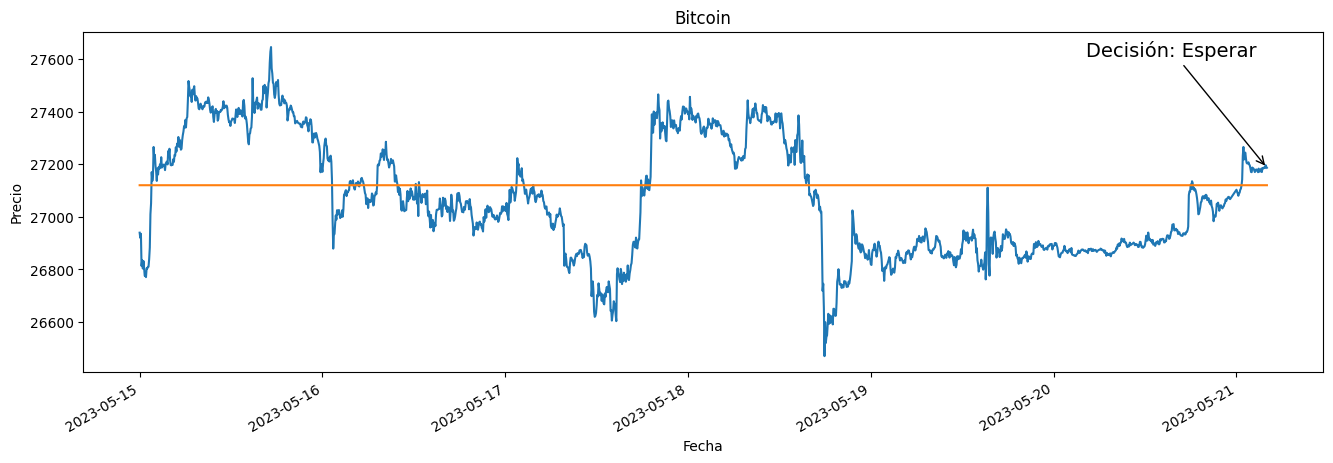

In [12]:
visualizacion()

#Automatizar

In [ ]:
from IPython.display import clear_output
import time

while True:
    clear_output()
    importar_base_bitcoin()
    extraer_tendencias()
    limpieza_datos()
    tomar_decisiones()
    visualizacion()
    time.sleep(300)